# Combinatoric optimization: choosing the best features

##### Keywords: simulated annealing, proposal,  energy, optimization, global minimum,  combinatoric optimization, local search, local minimum

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Contents
{:.no_toc}
* 
{: toc}

## The baseball data set

(from Givens and Hoeting, which this discussion follows)

```
Source: Baseball data from M.R. Watnik (1998), "Pay for Play: Are
Baseball Salaries Based on Performance", Journal of Statistics
Education, Volume 6, number 2
(http://www.amstat.org/publications/jse/v6n2/datasets.watnik.html)

Description: Salaries in 1992 and 27 performance statistics for 337 baseball
players (no pitchers) in 1991.


salary ($1000s)
average = batting average
obp = on base percentage
runs = runs scored
hits
doubles
triples
homeruns
rbis = runs batted in
walks
sos = strike outs
sbs = stolen bases
errors
freeagent (or eligible for free agency)
arbitration (or eligible for arbitration)
runsperso = runs/sos
hitsperso = hits/sos
hrsperso = homeruns/sos
rbisperso = rbis/sos
walksperso = walks/sos
obppererror = obp/errors
runspererror = runs/errors
hitspererror = hits/errors
hrspererror = homeruns/errors
soserrors = sos*errors
sbsobp = sbs*obp
sbsruns = sbs*runs
sbshits = sbs*hits
```

We wish to solve a prediction problem:  can we predict baseball player salaries from various statistics about the player? Specifically, we would like to choose an optimal set of features that would give us good predictions, and we want to be parsimonius about these features so that we dont overfit.

With 27 features, there are possibly $2^{27}$ models! So there is no way we are going to be able to do an exhaustive search.

In [4]:
baseball = pd.read_table("data/baseball.dat", sep='\s+')
baseball.head()

,salary,average,obp,runs,hits,doubles,triples,homeruns,rbis,walks,sos,sbs,errors,freeagent,arbitration,runsperso,hitsperso,hrsperso,rbisperso,walksperso,obppererror,runspererror,hitspererror,hrspererror,soserrors,sbsobp,sbsruns,sbshits
0,3300,0.272,0.302,69,153,21,4,31,104,22,80,4,4,1,0,0.8625,1.9125,0.3875,1.3000,0.2750,0.0755,17.2500,38.2500,7.7500,320,1.208,276,612
1,2600,0.269,0.335,58,111,17,2,18,66,39,69,0,4,1,0,0.8406,1.6087,0.2609,0.9565,0.5652,0.0838,14.5000,27.7500,4.5000,276,0.000,0,0
2,2500,0.249,0.337,54,115,15,1,17,73,63,116,6,6,1,0,0.4655,0.9914,0.1466,0.6293,0.5431,0.0562,9.0000,19.1667,2.8333,696,2.022,324,690
3,2475,0.260,0.292,59,128,22,7,12,50,23,64,21,22,0,1,0.9219,2.0000,0.1875,0.7812,0.3594,0.0133,2.6818,5.8182,0.5455,1408,6.132,1239,2688
4,2313,0.273,0.346,87,169,28,5,8,58,70,53,3,9,0,1,1.6415,3.1887,0.1509,1.0943,1.3208,0.0384,9.6667,18.7778,0.8889,477,1.038,261,507


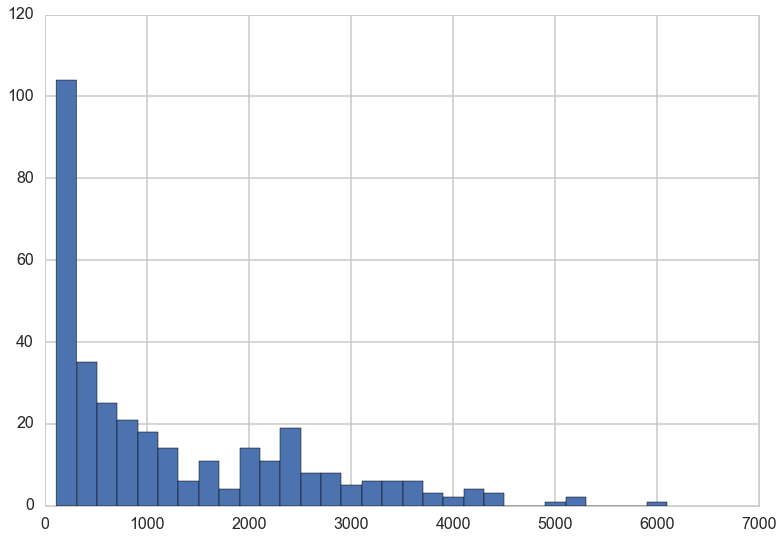

In [7]:
baseball.salary.hist(bins=30)

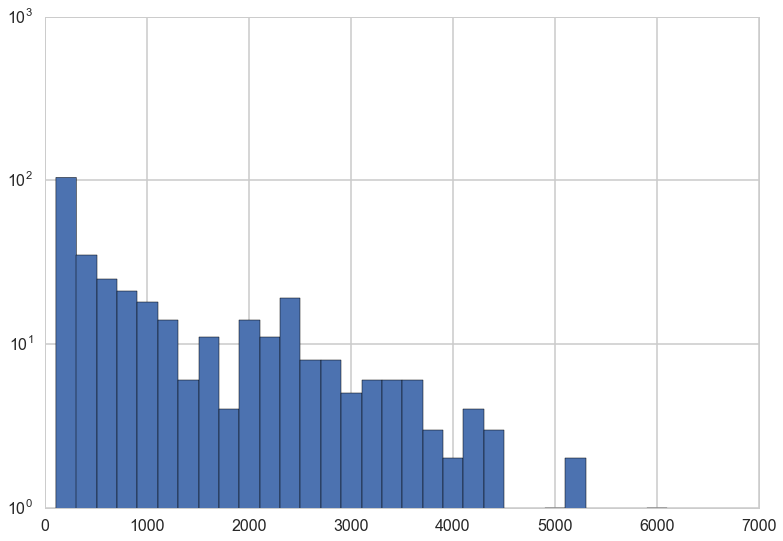

In [9]:
baseball.salary.hist(bins=30)
plt.yscale('log')

Since the salaries are highly skewed, a log transform on the salaries is a good idea.

In [12]:
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

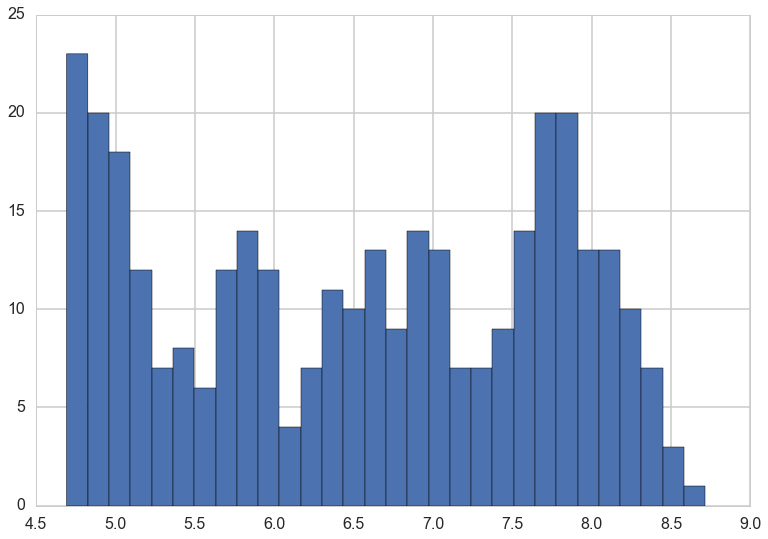

In [15]:
plt.hist(logsalary,  bins=30);

## AIC for linear regression

The AIC for a model is the training deviance plus twice the number of parameters.

$$AIC = D_{train} + 2p$$

where the deviance is defined as:

$$D(q) = -2 \sum_i log(q_i)$$,

That is, -2 times the log likelihood of the model.

So, one we find the MLE solution for the linear regression, we plugin the values we get, which are

$$\sigma_{MLE}^2 =  \frac{1}{N} SSE $$

where SSE is the sum of the  squares of the errors.

$$AIC = -2(-\frac{N}{2}(log(2\pi) + log(\sigma^2)) -2(-\frac{1}{2\sigma_{MLE}^2} \times SSE) + 2p$$

Thus:

$$AIC = Nlog(SSE/N) + 2p + constant$$

In [16]:
from sklearn.linear_model import LinearRegression
aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

## Local Search with random starts

The code for this part is taken from Chris Fonnesbeck's Bios 8366 Lecture Notes.

Combinatoric  problems are hard, so we turn to **Heuristics**. These have no guarantee of a global minimum, but do reasonably well, especially if you run them multiple times and try different starts.

The basic idea is to start with some solution, and perturb it a bit to get another solution in the **"local"** neighborhood of the initial solution. The point here is to not be exhaustive, but rather, to limit the search.

We want to start with different randomly chosen solutions, since local search can get trapped in local minima.

Here we start at 5 different initial solutions as to which features to choose, and run the local search algorithm for 15 iterations, starting from each of these 5 initial solutions.

In [18]:
nstarts = 5
iterations = 15
runs = np.random.binomial(1, 0.5, ncols*nstarts).reshape((nstarts,ncols)).astype(bool)
runs

array([[False,  True, False,  True, False,  True,  True, False,  True,
        False, False,  True, False,  True, False,  True, False, False,
        False, False, False, False,  True, False, False,  True,  True],
       [ True, False,  True,  True, False, False,  True,  True, False,
         True, False, False, False, False, False, False,  True, False,
        False,  True, False, False,  True, False, False, False, False],
       [False,  True,  True, False,  True, False,  True, False,  True,
        False,  True,  True, False,  True, False,  True, False, False,
        False,  True,  True, False, False,  True,  True, False,  True],
       [False,  True,  True,  True, False, False,  True, False, False,
        False, False,  True,  True, False, False, False, False, False,
        False,  True,  True,  True,  True,  True, False, False, False],
       [False,  True,  True, False,  True,  True, False, False, False,
        False, False,  True, False, False, False, False,  True, False,
  

Here is our algorithm.

1. For each start,for each iteration
    1. with our initial predictors we fit for the regression and calculate the aic
    2. we now get the 1-change neighborhhod by:
        1. systematically flipping each column and calculating the aic
        2. find the minimum aic for the process and record the predictors
    3. go to A and repeat for the latest  predictors
    4. record the solution for this starting point and go to 1.

In [19]:
from sklearn.linear_model import LinearRegression

runs_aic = np.empty((nstarts, iterations))

for i in range(nstarts):
    
    run_current = runs[i]
    
    for j in range(iterations):
        
        # Extract current set of predictors
        run_vars = predictors[predictors.columns[run_current]]
        g = LinearRegression().fit(X=run_vars, y=logsalary)
        run_aic = aic(g, run_vars, logsalary)
        run_next = run_current
        
        # Test all models in 1-neighborhood and select lowest AIC
        for k in range(ncols):
            run_step = run_current.copy()
            run_step[k] = not run_current[k]
            run_vars = predictors[predictors.columns[run_step]]
            g = LinearRegression().fit(X=run_vars, y=logsalary)
            step_aic = aic(g, run_vars, logsalary)
            if step_aic < run_aic:
                run_next = run_step.copy()
                run_aic = step_aic
            
        run_current = run_next.copy()
        runs_aic[i,j] = run_aic
        
    runs[i] = run_current
                

These are the final variable selections for our runs.

In [20]:
runs

array([[False,  True,  True, False, False,  True, False,  True, False,
         True, False,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False,  True,  True, False],
       [ True, False,  True, False, False, False, False,  True, False,
         True, False, False,  True,  True,  True,  True, False, False,
        False, False, False, False, False,  True, False, False, False],
       [False,  True,  True, False, False, False, False,  True, False,
         True, False, False,  True,  True,  True,  True, False, False,
        False, False, False, False, False,  True,  True, False,  True],
       [False, False,  True, False, False,  True, False,  True, False,
         True, False, False,  True,  True, False, False, False, False,
        False,  True,  True,  True, False,  True,  True, False, False],
       [False, False,  True, False, False,  True, False,  True, False,
         True, False, False,  True,  True, False, False, False, False,
  

We can plot how the aic evolves in the 5 random starts

(-430, -380)

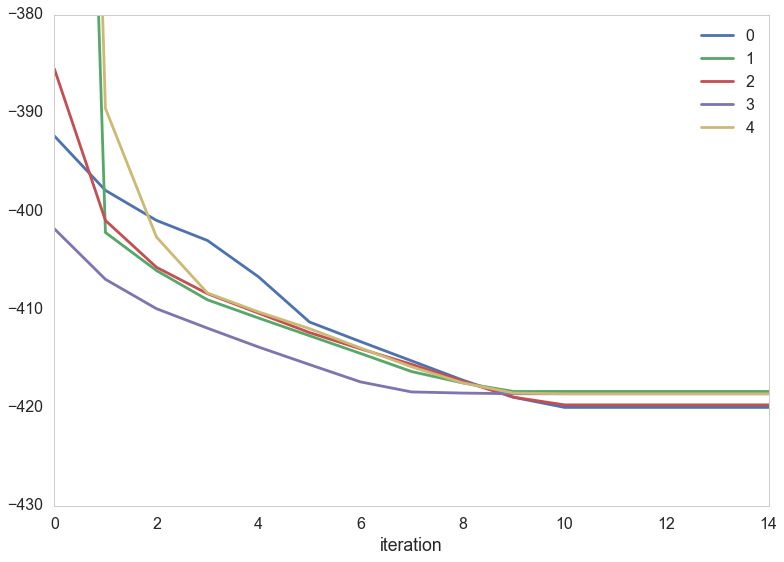

In [37]:
pd.DataFrame(runs_aic).T.plot(grid=False)
plt.xlabel('iteration')
plt.ylim([-430, -380])

In [34]:
for i in range(5):
    print(i, np.min(runs_aic[i]))

0 -420.000042669
1 -418.380197435
2 -419.743167044
3 -418.611888647
4 -418.611888647


To see which features are really important, see how many of the 5 starts solutions do they appear in...

In [267]:
pd.Series(runs.sum(0), index=predictors.columns).sort_values(ascending=False)

arbitration     5
rbis            5
freeagent       5
obppererror     4
sos             4
hitsperso       3
sbshits         3
hitspererror    3
sbsobp          3
soserrors       2
runs            2
hrsperso        2
runsperso       2
triples         2
walks           2
walksperso      1
hits            1
average         1
sbsruns         1
rbisperso       1
sbs             0
errors          0
homeruns        0
hrspererror     0
doubles         0
obp             0
runspererror    0
dtype: int64

And we can also query what the use of features in the final solutions was...

In [23]:
for i in range(nstarts):
    print(np.where(runs[i]==True))

(array([ 1,  2,  5,  7,  9, 11, 12, 13, 14, 15, 24, 25]),)
(array([ 0,  2,  7,  9, 12, 13, 14, 15, 23]),)
(array([ 1,  2,  7,  9, 12, 13, 14, 15, 23, 24, 26]),)
(array([ 2,  5,  7,  9, 12, 13, 19, 20, 21, 23, 24]),)
(array([ 2,  5,  7,  9, 12, 13, 19, 20, 21, 23, 24]),)


## Simulated Annealing

In [25]:
bbinits=dict(solution=np.random.binomial(1, 0.5, ncols).astype(bool),
               length=100, T=100)

In [26]:
def efunc(solution):
    solution_vars = predictors[predictors.columns[solution]]
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    return aic(g, solution_vars, logsalary)
def pfunc(solution):
    flip = np.random.randint(0, ncols)
    solution_new = solution.copy()
    solution_new[flip] = not solution_new[flip]
    return solution_new

In [27]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    for index in range(epochs):
        print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
        print("Temperature", T, "Length", length)
        for it in range(length):
            total+=1
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Revert solution
                accumulator.append((T, old_solution, old_energy))
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

In [38]:
import math
tf2 = lambda temp: 0.8*temp
itf2 = lambda length: math.ceil(1.2*length)
bb_bmeta, bb_bs, bb_be, bb_out = sa(efunc, bbinits, 25, tf2, itf2, pfunc)

Epoch 0
Temperature 100 Length 100
Epoch 1
Temperature 80.0 Length 120
Epoch 2
Temperature 64.0 Length 144
Epoch 3
Temperature 51.2 Length 173
Epoch 4
Temperature 40.96000000000001 Length 208
Epoch 5
Temperature 32.76800000000001 Length 250
Epoch 6
Temperature 26.21440000000001 Length 300
Epoch 7
Temperature 20.97152000000001 Length 360
Epoch 8
Temperature 16.777216000000006 Length 432
Epoch 9
Temperature 13.421772800000006 Length 519
Epoch 10
Temperature 10.737418240000006 Length 623
Epoch 11
Temperature 8.589934592000004 Length 748
Epoch 12
Temperature 6.871947673600004 Length 898
Epoch 13
Temperature 5.497558138880003 Length 1078
Epoch 14
Temperature 4.398046511104003 Length 1294
Epoch 15
Temperature 3.5184372088832023 Length 1553
Epoch 16
Temperature 2.814749767106562 Length 1864
Epoch 17
Temperature 2.25179981368525 Length 2237
Epoch 18
Temperature 1.8014398509482001 Length 2685
Epoch 19
Temperature 1.4411518807585602 Length 3222
Epoch 20
Temperature 1.1529215046068482 Length 3867

In [39]:
bb_bmeta, bb_bs, bb_be

({'index': 18619, 'temp': 1.4411518807585602},
 array([False,  True,  True, False, False,  True, False,  True, False,
         True, False, False,  True,  True,  True,  True, False, False,
        False, False, False, False, False,  True,  True,  True, False], dtype=bool),
 -420.94721143715481)

Best AIC: -420.9472114371548
Best solution: (array([ 1,  2,  5,  7,  9, 12, 13, 14, 15, 23, 24, 25]),)
Discovered at iteration 18618


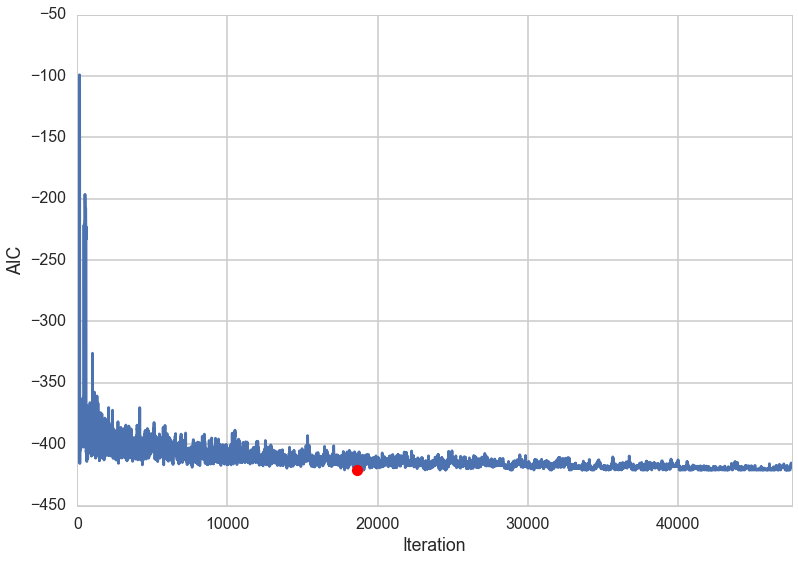

In [40]:
aic_values = [e[2] for e in bb_out]
plt.plot(aic_values)
plt.xlim(0, len(aic_values))
plt.xlabel('Iteration')
plt.ylabel('AIC')
print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(bb_be, 
            np.where(bb_bs==True),
            np.where(aic_values==bb_be)[0][0]))
plt.plot(np.where(aic_values==bb_be)[0][0], bb_be, 'ro')